## Python Scripts For Operational Tasks

In [69]:
# Downloading the most recent GOES-16 multi-band file from AWS
# To do this, we will filter the links on Brian Blaylock's webpage with BeautifulSoup
from bs4 import BeautifulSoup
import urllib2
from datetime import datetime, timedelta
from time import sleep

# Start a while loop to catch any errors within the downloaded netcdf file
loop = True
while loop: 
    # We need to create the url to go fetch the file

    # Get current UTC time
    time = datetime.utcnow()
    date = datetime.strftime(time, '%Y-%m-%d')
    hour = datetime.strftime(time, '%H')

    # Make the URL based on the current date and time
    main = 'http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?source=aws&domain=C&product=ABI-L2-MCMIP&date='
    url = main + date + '&hour=' + hour
    html = urllib2.urlopen(url).read()
    soup = BeautifulSoup(html)
    stuff = soup.select('a[href*=noaa-goes16.s3.amazonaws.com]') # Select links from the webpage that are to the AWS server

    # What about if the first file for the current hour hasn't been uploaded yet (a problem from xx:00 to xx:05 or so)
    try:
        latest_url = stuff[-1]['href'] # Selecting the the last link in the list as it will be the most recent 
    except:
        delta = timedelta(hours=1)
        time = datetime.utcnow() - delta # Go back to the previous hour
        date = datetime.strftime(time, '%Y-%m-%d')
        hour = datetime.strftime(time, '%H')

        url = main + date + '&hour=' + hour
        html = urllib2.urlopen(url).read()
        soup = BeautifulSoup(html)
        stuff = soup.select('a[href*=noaa-goes16.s3.amazonaws.com]')

        latest_url = stuff[-1]['href']

    # file to be written to
    file = 'a_smol_cdf.nc'
    fh = open(file, 'w')
    response = urllib2.urlopen(latest_url)
    print 'Latest url:' + latest_url
    fh.write(response.read())
    fh.close()

    from netCDF4 import Dataset
    C_file = file
    C = Dataset(C_file, 'r')
    try:
        print 'Testing file...'
        B = C.variables['CMI_C16'][:]
        loop = False
    except:
        print 'Corrupted netCDF file, trying again in 30 seconds'
        sleep(30)

print 'Download successful!'

Latest url:https://noaa-goes16.s3.amazonaws.com/ABI-L2-MCMIPC/2018/329/00/OR_ABI-L2-MCMIPC-M3_G16_s20183290057184_e20183290059557_c20183290100061.nc
Testing file...
Download successful!


The script above can be run every 5 minutes to download the new netcdf file, and it will overwrite the old one.
To make the scripts operational so I can put them in the crontab, I define a function for each product. Then, call the function from your main script that goes in the crontab, and it will save your image to a file. 

In [70]:
def cloudphase(url):
    
    from netCDF4 import Dataset
    from datetime import datetime, timedelta
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap
    from pyproj import Proj

    # Read netcdf file
    C_file = url
    C = Dataset(C_file, 'r')

    # Get date and time
    add_seconds = C.variables['t'][0] # Number of seconds since year 2000
    add_seconds=int(add_seconds)
    DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

    # Load the RGB arrays
    R = C.variables['CMI_C13'][:] # IR Band 13
    G = C.variables['CMI_C02'][:] # "Red" Band 2 visible
    B = C.variables['CMI_C05'][:] # "Snow/Ice" Band 5

    # Apply range limits for each channel 
    G = np.clip(G, 0, .78) # These are albedo (range from 0 to 1)
    B = np.clip(B, .01, .59)
    # Normalize between 0 and 1
    G = (G-0)/(.78-0)
    B = (B-.01)/(0.59--0.01)
    # Range limits for IR channel
    Rmin=219.65 # Kelvin
    Rmax=280.65
    R = np.clip(R, Rmin, Rmax)
    R = (R-Rmin)/(Rmax-Rmin) # Normalize between the range
    R = 1. - R # Make cold brightness temperatures appear red

    # The final RGB array 
    RGB = np.dstack([R,G,B])

    # Satellite height, lon, sweep
    sat_h = C.variables['goes_imager_projection'].perspective_point_height
    sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin
    sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

    # The projection x and y coordinates 
    X = C.variables['x'][:] * sat_h
    Y = C.variables['y'][:] * sat_h

    # map object with pyproj
    p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

    # Convert map points to latitude and longitude with the magic provided by Pyproj
    XX, YY = np.meshgrid(X, Y)
    lons, lats = p(XX, YY, inverse=True)
    # Important: convert points where R is masked to be a point in the gulf of alaska
    lats[R.mask] = 57
    lons[R.mask] = -152

    # Make a new map object for the CONUS
    mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
                 width=1800*3000, height=1060*3000, \
                 lat_1=38.5, lat_2=38.5, \
                 lat_0=38.5, lon_0=-97.5)

    # Create a color tuple for pcolormesh
    rgb = RGB[:,:-1,:]
    colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array
    colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel plots faster

    # Plot the image
    plt.figure(figsize=[15,12])
    # Using pcolormesh instead of imshow because we need to use lat/lon arrays in this case
    newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
    newmap.set_array(None)
    mH.drawcoastlines()
    mH.drawcountries()
    mH.drawstates()

    plt.title('GOES-16 Day Cloud Phase Distinction', fontweight='semibold', fontsize=12, loc='left')
    plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), fontsize=11, loc='right')
    plt.savefig('cloudphase.png', bbox_inches='tight')

You can control where the file saves to by editing the filename in plt.safefig(). I save my files to the same location, overwriting the old ones. That way, the latest file can be uploaded to my website via sftp after the execution of the main script.

If you want to save the last x amount of images for processing into an animated gif, you can use the mv command to rename your existing files in your folder as shown below. I use the os module, to which you can pass the same commands you would type on the command line. 

In [ ]:
# Change the names/overwrite previous files
import os
os.chdir('/home/kschneider/Documents/goes16/Images/snowcover') # Change directory to directory with your images
band='snowcover'
images=20
last_image = band + str(images) + '.png'
command = 'rm ' + last_image # Removing the last image in the folder to maintain same number of images
os.system(command)
for num in range(0,(images-1)): # Files are numbered snowcover#.png where # ranges from 0 to images (20)
    newfname = band + str(images-num) + '.png' 
    oldfname = band + str(images-(num+1)) + '.png'
    command = 'mv ' + oldfname + ' ' + newfname # Example: snowcover1.png --> snowcover2.png
    os.system(command)
os.chdir('/home/kschneider') # Change back to directory containing netcdf file

### Important to do this step BEFORE creating a new snowcover1.png

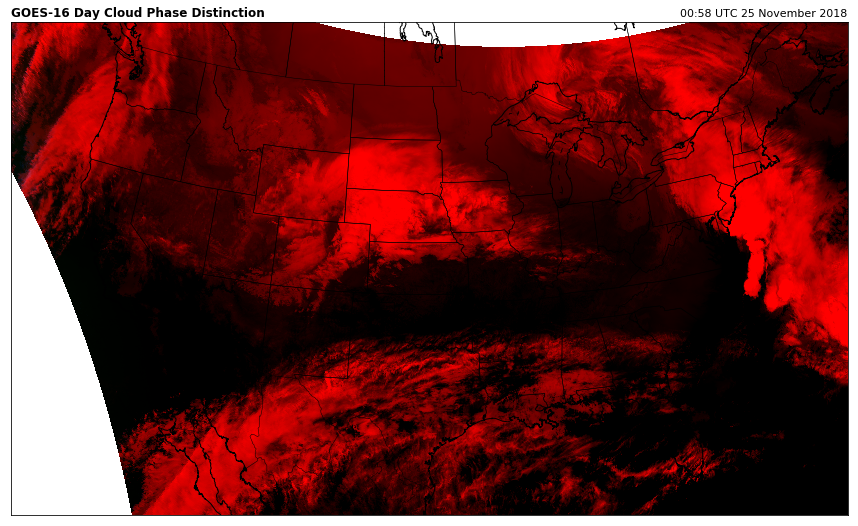

In [71]:
cloudphase(file)

Now, we can create a gif of the images. As they are numbered 1 to 20, with 1 being the most recent image, the gif will be creatd in the correct order. 

In [63]:
# Making a gif

import os
import imageio

png_dir = '/home/kschneider/Documents/goes16/Images/snowcover'
os.chdir(png_dir)

images = []
for file_name in os.listdir(png_dir):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('../snowcover.gif', images, fps=5) 
# I save my gifs in a different folder so they can be easily captured with put * (shown later)

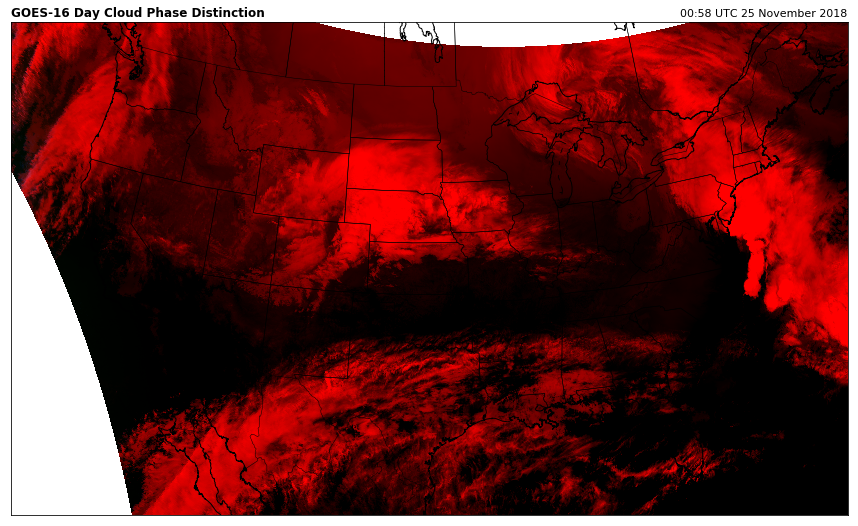

In [73]:
from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pyproj import Proj

# Read netcdf file
C_file = 'a_smol_cdf.nc'
C = Dataset(C_file, 'r')

# Get date and time
add_seconds = C.variables['t'][0] # Number of seconds since year 2000
add_seconds=int(add_seconds)
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Load the RGB arrays
R = C.variables['CMI_C13'][:] # IR Band 13
G = C.variables['CMI_C02'][:] # "Red" Band 2 visible
B = C.variables['CMI_C05'][:] # "Snow/Ice" Band 5

# Apply range limits for each channel 
G = np.clip(G, 0, .78) # These are albedo (range from 0 to 1)
B = np.clip(B, .01, .59)
# Normalize between 0 and 1
G = (G-0)/(.78-0)
B = (B-.01)/(0.59--0.01)
# Range limits for IR channel
Rmin=219.65 # Kelvin
Rmax=280.65
R = np.clip(R, Rmin, Rmax)
R = (R-Rmin)/(Rmax-Rmin) # Normalize between the range
R = 1. - R # Make cold brightness temperatures appear red

# The final RGB array 
RGB = np.dstack([R,G,B])

# Satellite height, lon, sweep
sat_h = C.variables['goes_imager_projection'].perspective_point_height
sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin
sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates 
X = C.variables['x'][:] * sat_h
Y = C.variables['y'][:] * sat_h

# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)
# Important: convert points where R is masked to be a point in the gulf of alaska
lats[R.mask] = 57
lons[R.mask] = -152

# Make a new map object for the CONUS
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
     width=1800*3000, height=1060*3000, \
     lat_1=38.5, lat_2=38.5, \
     lat_0=38.5, lon_0=-97.5)

# Create a color tuple for pcolormesh
rgb = RGB[:,:-1,:]
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel plots faster

# Plot the image
plt.figure(figsize=[15,12])
# Using pcolormesh instead of imshow because we need to use lat/lon arrays in this case
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)
mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()

plt.title('GOES-16 Day Cloud Phase Distinction', fontweight='semibold', fontsize=12, loc='left')
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), fontsize=11, loc='right')
plt.show()

#### Automating the generation of sub-region plots
It's useful to be able to also generate plots of sub-regions. How do we do this all in the same script? We can compactly generate plots of these regions by utilizing python dictionaries. All we have to do is choose a basemap projection that lets us specify lat/lon extents, and then iterate thru a dictionary containing them.

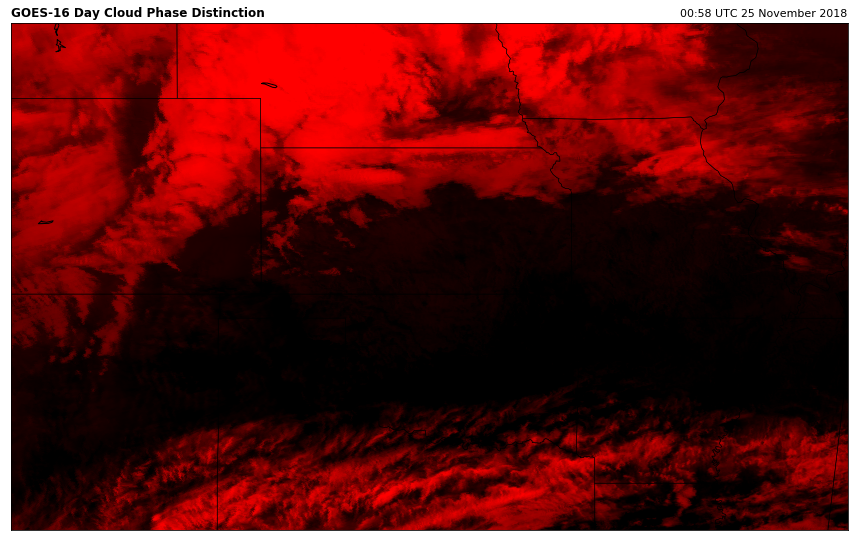

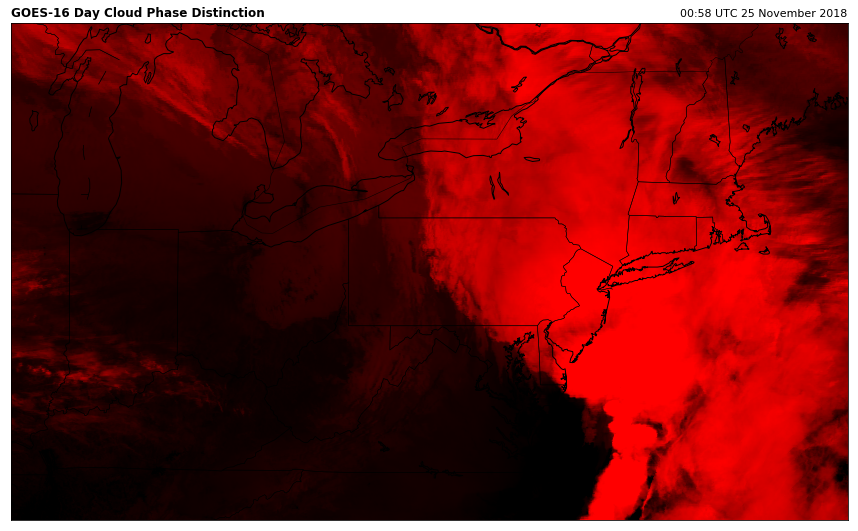

In [80]:
# Script to make gifs of sub-sections

# For the sub-sections, I will use the Miller Cylindrical projection. It requires:
# m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
             #llcrnrlon=-180,urcrnrlon=180,resolution='c')
    
# Make a dictionary to hold llc and urc lat and lon
# [llcrnrlat, urcrnrlat, llcrnrlon, urcrnrlon]
domains = {'Mid-Atlantic': [35.5, 46, -89, -68], 'Central Plains': [32, 42.5, -108, -88]}

# Iterate thru the dictionary to plot the sub-sectors
for key, value in domains.iteritems():
    sector = key
    lat0 = value[0]
    lat1 = value[1]
    lon0 = value[2]
    lon1 = value[3]
    m = Basemap(projection='mill',llcrnrlat=lat0,urcrnrlat=lat1,\
            llcrnrlon=lon0,urcrnrlon=lon1,resolution='i')
    # Plot the image
    plt.figure(figsize=[15,12])
    newmap = m.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
    newmap.set_array(None)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    plt.title('GOES-16 Day Cloud Phase Distinction', fontweight='semibold', fontsize=12, loc='left')
    plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), fontsize=11, loc='right')
    import os
    os.chdir('/home/kschneider/Documents/goes16')
    fig_name = 'cloudphase' + sector + '1.png'
    plt.savefig(fig_name, bbox_inches='tight')
    

### Automatically upload files to the web
There are many ways to do this, including python libraries, but to upload to my personal web space, sftp (secure FTP) protocol is required. Unfortunately, I was not able to get a python module installed that would do this (there are some available, but contained a lot of bugs). However, you can fairly easily write a compact shell script to do the trick, and call the script using subprocess. The shell script uses expect (yum install expect); google search should yield more info about it. 

In [ ]:
#!/usr/bin/expect

set timeout 300
spawn sftp [USERNAME]@ftp.[SERVER]
expect "[USERNAME]@ftp.[SERVER]'s password:"
send "[PASSWORD HERE]\n"
expect "sftp>"
send "cd [IMAGE DESTINATION]\n"
expect "sftp>"
send "lcd [YOUR IMAGE DIRECTORY]\n"
expect "sftp>"
send "put *\n"
expect "sftp>"
send "exit\n"
interact

Note: Change the timeout counter (in seconds) depending on your upload file size and frequency of upload. I have it set to 300 seconds (5 min) so it is forced to finish before the script executes again. 

In [ ]:
# Call the shell script in Python
import os
os.chdir('/home/kschneider/Documents/goes16')
import subprocess
subprocess.call(['./upload.sh'])